# Optimal HDBSCAN* Leaves

In [137]:
import numpy as np
from fast_hdbscan import HDBSCAN, LayerClustering

import requests
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (8, 8)})

In [138]:
data_request = requests.get(
    "https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/clusterable_data.npy?raw=true"
)
data = np.load(BytesIO(data_request.content))

## Layered HDBSCAN* clustering

The layered clustering algorithm computes HDBSCAN* leaf clusters with an
increasing minimum cluster size threshold. The starting minimum cluster size is
specified by either `base_n_clusters` (binary search to a size that gives the
specified number of leaves) or `base_min_cluster_size` (initial value to use).
Then the `next_cluster_size_quantile` controls which size is used as the next
threshold. The process continues until `min_cluster` leaves remain or the size
increased by a single point. 

Each evaluated minimum cluster size creates a *layer* of cluster labels:

Layer 0 found 39 clusters
Layer 1 found 12 clusters
Layer 2 found 6 clusters
Layer 3 found 3 clusters


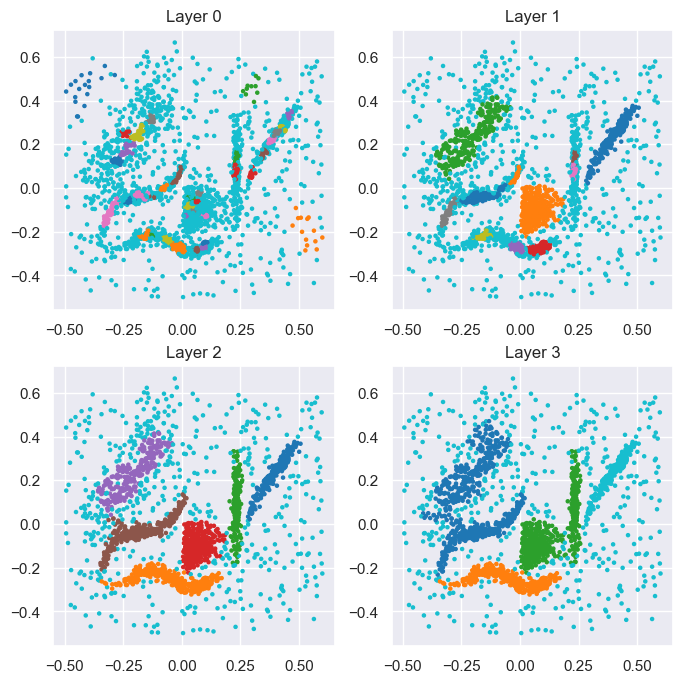

In [139]:
layers = LayerClustering(verbose=True).fit(data)

for i, labels in enumerate(layers.cluster_layers_):
    plt.subplot(2, 2, i + 1)
    plt.scatter(
        data[:, 0], data[:, 1], c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0
    )
    plt.title(f"Layer {i}")
plt.show()

The layer with the fewest noise points is selected as final clustering:

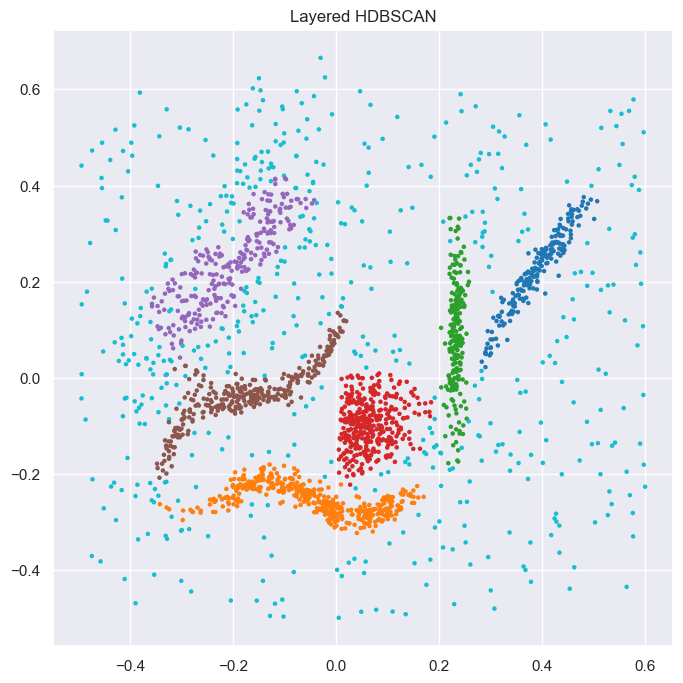

In [140]:
plt.scatter(
    data[:, 0], data[:, 1], c=layers.labels_ % 10, s=5, cmap="tab10", vmax=9, vmin=0
)
plt.title("Layered HDBSCAN")
plt.show()

The clusters in these layers form a leaf-cluster tree, describing how the leaf
clusters merge at larger minimum sizes. The resulting hierarchy has edges across
multiple layers because a leaf's parent may not become a leaf immediately after 
the leaf's death. The resulting hierarchy is also not a binary tree. 

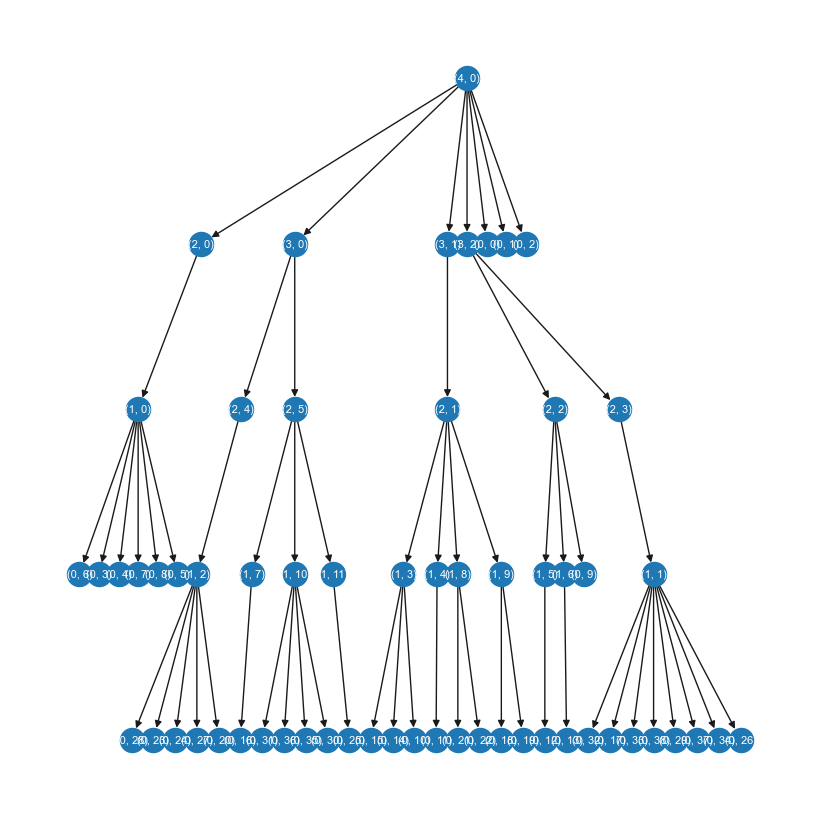

In [141]:
import networkx as nx

g = nx.from_dict_of_lists(layers.cluster_tree_, nx.DiGraph())
pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
nx.draw(g, pos, with_labels=True, font_size=8, font_color="white")
plt.show()

## Exact multi-scale leaf-cluster tree

It is possible to compute the exact leaf-cluster tree for a moving minimum
cluster size threshold. The idea is equivalent to computing a single linkage
hierarchy from a minimum spanning tree. The procedure below iterates over the
condensed tree leaves in increasing size. In each iteration all leaves with the
smallest size are processed. Their deaths are recorded and the remaining
condensed tree is inspected to determine whether the parent segment has become a
leaf. The process continuous until a single leaf remains and computes the
condensed hierarchy only once! 

In [142]:
def extract_leaves(raw_tree, n_points, min_size):
    # Input
    cluster_tree = raw_tree[raw_tree["child_size"] > 1].copy()

    # Output
    leaves = dict()  # {leaf_id: {birth: int, death: int, parent: int}}

    # Find the leaves
    n_nodes = cluster_tree["child"].max() + 1
    leaf_mask = np.ones(n_nodes - n_points, dtype=np.bool_)
    leaf_mask[cluster_tree["parent"] - n_points] = False
    for leaf_id in np.where(leaf_mask)[0] + n_points:
        leaves[leaf_id] = dict(birth=min_size)

    # Iteratively prune lowest size leaves
    while leaf_mask.sum() > 1:
        # Extract rows with child leaves
        row_mask = leaf_mask[cluster_tree["child"] - n_points]
        leaf_sizes = cluster_tree["child_size"][row_mask]

        # Find the leaves sharing the smallest size (maybe use a queue instead?)
        leaf_ids = np.where(leaf_mask)[0] + n_points
        min_size = leaf_sizes.min()
        leaf_leaf_idx = np.where(leaf_sizes == min_size)[0]

        # Iterate over all leaves with the smallest size
        for leaf_id in leaf_ids[leaf_leaf_idx]:
            # Find the cluster tree row
            leaf_idx = np.searchsorted(cluster_tree["child"], leaf_id)
            parent = cluster_tree["parent"][leaf_idx]

            # Find the sibling row
            sibling_idx = leaf_idx + (((leaf_idx % 2) * -2) + 1)
            sibling_id = cluster_tree["child"][sibling_idx]

            # Add the leaf's death and condensed tree parent
            leaves[leaf_id].update(dict(death=int(min_size + 1), parent=int(parent)))
            leaf_mask[leaf_id - data.shape[0]] = False

            # Update the cluster tree to skip the sibling
            cluster_tree["parent"][cluster_tree["parent"] == sibling_id] = parent

            # Check if sibling is a to-be-processed leaf
            if leaf_mask[sibling_id - data.shape[0]]:
                # Also add a death for the sibling
                leaves[sibling_id].update(
                    dict(death=int(min_size + 1), parent=int(parent))
                )
                leaf_mask[sibling_id - data.shape[0]] = False
                # Add a birth for the parent
                leaves[parent] = dict(birth=int(min_size + 1))
                leaf_mask[parent - data.shape[0]] = True

    # Use first cluster tree ancestor that becomes a leave as parent
    # root = raw_tree["parent"][0]
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    for attrs in leaves.values():
        if "parent" not in attrs:
            continue
        parent = attrs["parent"]
        while parent not in leaves:
            idx = np.searchsorted(cluster_tree["child"], parent)
            parent = int(cluster_tree["parent"][idx])
        attrs["parent"] = parent

    return leaves, cluster_tree

In [143]:
# Compute initial condensed tree
c = HDBSCAN(min_cluster_size=5).fit(data)

# Extract leaves-tree from the condensed tree
leaves, cluster_tree = extract_leaves(c._condensed_tree, data.shape[0], c.min_cluster_size)

### Quality measures

Computing the number of noise points at each minimum cluster size is trivial.

In [144]:
def num_points_in_clusters(leaves):
    max_death = max(leaf.get("death", 0) + 1 for leaf in leaves.values())
    clustered_points = np.zeros(max_death)

    for leaf_id, attrs in leaves.items():
        tree_idx = np.searchsorted(cluster_tree["child"], leaf_id)
        item_size = cluster_tree["child_size"][tree_idx]
        min_size = attrs["birth"]
        max_size = attrs.get("death", max_death - 1)
        clustered_points[min_size:max_size] += item_size

    return clustered_points

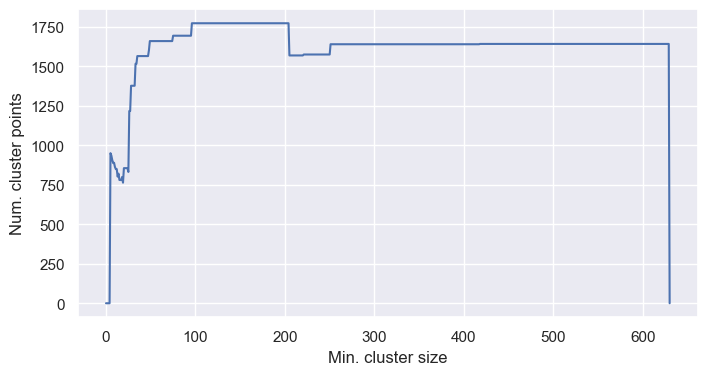

In [145]:
# List the number of points in each leaf birth and death
clustered_points = num_points_in_clusters(leaves)

plt.figure(figsize=(8, 4))
plt.plot(clustered_points)
plt.xlabel("Min. cluster size")
plt.ylabel("Num. cluster points")
plt.show()

Computing condensed-tree stability for leaf-clusters at the different minimum
cluster sizes:

- only compute persistence between min_cluster_size birth and death.
- consider points in all cluster_tree child segments.
- compute persistence as $\lambda_{enter} - \lambda_{death}$
- compute stability as the sum of persistences for the points in a segment
  - the initial min cluster size points enter at the density at which the
    segment meets the minimum cluster size threshold!
  - other points enter at their density in the condensed tree.
- aggregate stabilities over all leaf-clusters.

In [146]:
def bf_children(cluster_tree, segment_id):
    """Extracts points in the condensed tree below the leaf_id segment."""
    to_process = [segment_id]
    result = []

    while len(to_process) > 0:
        result.extend(to_process)
        to_process = cluster_tree["child"][
            np.isin(cluster_tree["parent"], to_process, assume_unique=True)
        ]
    return result


def compute_leaf_stability(leaf_id, leaf, cluster_tree, points_tree):
    """Computes the lambda persistence curve of a leaf-cluster tree segment."""
    # Find the cluster's points in the condensed tree and list min, max size and
    # death density.
    min_size = leaf["birth"]
    if "death" in leaf:
        max_size = leaf["death"]
        segment_ids = bf_children(cluster_tree, leaf_id)
        segment_points = points_tree[np.isin(points_tree["parent"], segment_ids)]
        lambda_death = cluster_tree["lambda_val"][cluster_tree["child"] == leaf_id][0]
    else:
        max_size = points_tree.shape[0]
        segment_points = points_tree
        lambda_death = 0

    # Find lambda values for points entering the cluster within its size range.
    # The partition lets us sort just the points in the size range.
    leaf_size = segment_points.shape[0]
    indices = [leaf_size - max_size + 1, leaf_size - min_size + 1]
    lambdas = np.partition(segment_points["lambda_val"], indices)
    lambda_births = np.sort(lambdas[indices[0] : indices[1]])[::-1]

    # Create arrays for use with plt.pcolormesh
    #   min cluster size
    birth_size = np.arange(min_size, max_size)
    #   persistence = lambda_births - lambda_death
    persistences = lambda_births - lambda_death
    #   stability = min_size * (birth - death) + sum(enter - death)
    stability = (birth_size - 1) * persistences + np.cumsum(persistences[::-1])[::-1]
    return stability


def compute_stabilities(raw_tree, leaves):
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    points_tree = raw_tree[raw_tree["child_size"] == 1]

    for leaf_id, leaf in leaves.items():
        leaf["stability"] = compute_leaf_stability(
            leaf_id, leaf, cluster_tree, points_tree
        )

    max_death = max(leaf.get("death", 0) + 1 for leaf in leaves.values())
    total_stability = np.zeros(max_death)
    for leaf in leaves.values():
        if "death" in leaf:
            stability = leaf["stability"]
            min_size = leaf["birth"]
            max_size = min_size + stability.shape[0]
            total_stability[min_size:max_size] += stability

    return total_stability

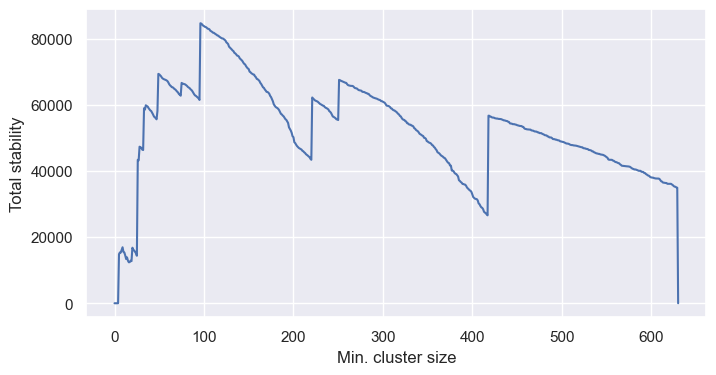

In [147]:
total_stability = compute_stabilities(c._condensed_tree, leaves)

fig = plt.figure(figsize=(8, 4))
plt.plot(total_stability)
plt.ylabel("Total stability")
plt.xlabel("Min. cluster size")
plt.show()

### Straight min_cluster_size cuts

A straight min_cluster_size cut seems most appropriate to select clusters. The
clusters selected by such a cut can vary in density and do not have to form a
straight cut in the condensed tree.

Maximizing the total stability works and relates to minimizing the number of
noise points. The total stability at a particular minimum cluster size is a sum
of density persistences over all points in the clusters at that threshold. That
signal contains the noise point trace. In addition, the stability of each
leaf-cluster is always largest at its birth. I think that means that the total
stability has a maximum when the number of noise points is minimal. Maybe there
are weird cases where it does not hold?

The optimal minimum cluster size has the lowest number of noise points or
highest total stability (equivalent in this case), finding the same labelling as
`LayerClustering`:

In [148]:
from fast_hdbscan.cluster_trees import (
    get_cluster_label_vector,
    get_point_membership_strength_vector,
)


def optimal_clustering(raw_tree, leaves, total_stability, n_points):
    # best_size = np.argmax(clustered_points)
    best_size = np.argmax(total_stability)
    select_leaves = [
        leaf_id
        for leaf_id, attrs in leaves.items()
        if attrs["birth"] <= best_size and attrs.get("death", np.inf) > best_size
    ]

    labels = get_cluster_label_vector(
        raw_tree, select_leaves, cluster_selection_epsilon=0.0, n_samples=n_points
    )
    probs = get_point_membership_strength_vector(raw_tree, select_leaves, labels)
    return labels, probs, best_size

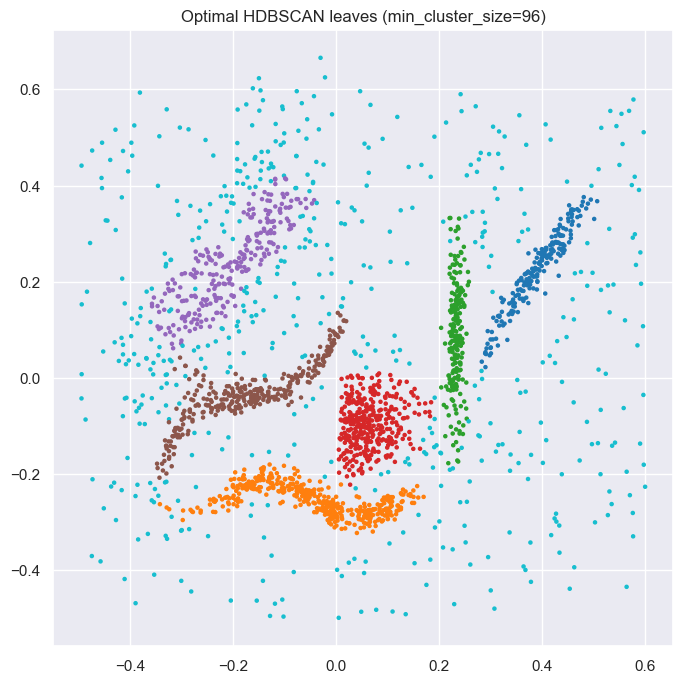

In [149]:
labels, probs, best_size = optimal_clustering(
    c._condensed_tree, leaves, total_stability, data.shape[0]
)
plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title(f"Optimal HDBSCAN leaves (min_cluster_size={best_size})")
plt.show()

### Leaf-cluster tree plot

Plotting the leaf-cluster tree with `plt.pcolormesh`. Icicle widths indicate the
cluster's stability at that minimum cluster size. Icicle color indicates the
total stability over all clusters at that minimum cluster size.

In [150]:
import warnings
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap


# Depth first traversal to order the leaf clusters
def df_leaf_order(children, id):
    order = [id]
    if id in children:
        for child in sorted(
            children[id], key=lambda x: leaves[x]["death"], reverse=True
        ):
            order += df_leaf_order(children, child)
    return order


def compute_x_coords(leaves, root):
    # Convert to directed graph
    children = dict()
    for leaf_id, attrs in leaves.items():
        if "parent" not in attrs:
            continue
        parent = attrs["parent"]
        if parent not in children:
            children[parent] = []
        children[parent].append(leaf_id)

    # List x-coordinates
    return {leaf: i for i, leaf in enumerate(df_leaf_order(children, root))}


class LeafClusterTree:
    def __init__(self, labels, condensed_tree, leaves, total_stability):
        self.labels = labels
        self.condensed_tree = condensed_tree
        self.leaves = leaves
        self.total_stability = total_stability
        self.max_stability = max(leaf["stability"].max() for leaf in leaves.values())
        self.max_total_stability = total_stability.max()

    def as_pandas(self):
        import pandas as pd

        return pd.DataFrame.from_dict(self.leaves, orient="index")

    def _select_clusters(self):
        selected_clusters = dict()
        for row in self.condensed_tree[self.condensed_tree["child_size"] == 1]:
            label = self.labels[row["child"]]
            if label >= 0:
                selected_clusters[label] = min(
                    selected_clusters.get(label, np.inf), row["parent"]
                )
        cluster_tree = self.condensed_tree[self.condensed_tree["child_size"] > 1]
        for label, leaf_id in selected_clusters.items():
            while leaf_id not in self.leaves:
                idx = np.searchsorted(cluster_tree["child"], leaf_id)
                leaf_id = cluster_tree["parent"][idx]
            selected_clusters[label] = leaf_id

        return selected_clusters

    def plot(
        self,
        inf_padding=0.1,
        min_width=0.05,
        max_width=4,
        cmap="viridis",
        colorbar=True,
        colorbar_kws=None,
        death_line_kws=None,
        connect_line_kws=None,
        indicator_radius=30,
        indicator_offset=8,
        selection_palette=None,
    ):
        if colorbar_kws is None:
            colorbar_kws = dict()
        max_width = (max_width - min_width) / 2
        max_death = max(leaf.get("death", 0) for leaf in self.leaves.values())
        inf_value = round((1 + inf_padding) * max_death)
        x_coords = compute_x_coords(self.leaves, min(self.leaves.keys()))

        _death_line_kws = dict(linestyle=":", color="black", linewidth=0.5)
        if death_line_kws is not None:
            _death_line_kws.update(death_line_kws)
        plt.gca().add_collection(
            LineCollection(
                [
                    [
                        (x_coords[leaf_id], leaf["death"]),
                        (x_coords[leaf_id], self.leaves[leaf["parent"]]["birth"]),
                    ]
                    for leaf_id, leaf in self.leaves.items()
                    if "death" in leaf
                ],
                **_death_line_kws
            )
        )

        _connect_line_kws = dict(linestyle="-", color="black", linewidth=0.5)
        if connect_line_kws is not None:
            _connect_line_kws.update(connect_line_kws)
        plt.gca().add_collection(
            LineCollection(
                [
                    [
                        (x_coords[leaf_id], self.leaves[leaf["parent"]]["birth"]),
                        (
                            x_coords[leaf["parent"]],
                            self.leaves[leaf["parent"]]["birth"],
                        ),
                    ]
                    for leaf_id, leaf in self.leaves.items()
                    if "parent" in leaf
                ],
                **_connect_line_kws
            )
        )

        for leaf_id, leaf in self.leaves.items():
            stability = leaf["stability"]
            min_size = leaf["birth"]
            max_size = min(min_size + stability.shape[0], inf_value)

            # Y dimension:
            sizes = np.arange(min_size, max_size)
            # X dimension:
            stability = stability[: max_size - min_size]
            xs = x_coords[leaf_id] + np.asarray([[-min_width / 2], [min_width / 2]])
            widths = xs + stability / self.max_stability * max_width * np.array(
                [[-1], [1]]
            )
            # Color dimensions:
            total_stability = self.total_stability[min_size:max_size]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                bar = plt.pcolormesh(
                    widths,
                    np.broadcast_to(sizes, (2, len(sizes))),
                    np.broadcast_to(total_stability, (2, len(sizes))),
                    vmin=0,
                    vmax=self.max_total_stability,
                    edgecolors="none",
                    linewidth=0,
                    cmap=cmap,
                )

        if indicator_radius > 0:
            if selection_palette is None:
                selection_palette = plt.cm.tab10.colors
            leaf_labeling = self._select_clusters()
            leaf_labels, leaf_xs, leaf_births = zip(
                *[
                    (
                        label % len(selection_palette),
                        x_coords[leaf_id],
                        self.leaves[leaf_id]["birth"] - indicator_offset,
                    )
                    for label, leaf_id in leaf_labeling.items()
                ]
            )
            plt.scatter(
                leaf_xs,
                leaf_births,
                s=indicator_radius,
                c=leaf_labels,
                cmap=ListedColormap(selection_palette),
                vmin=0,
                vmax=len(selection_palette) - 1,
                zorder=10,
            )

        if colorbar:
            if "fraction" in colorbar_kws:
                bbox = plt.gca().get_window_extent()
                ax_width, ax_height = bbox.width, bbox.height
                colorbar_kws["aspect"] = ax_height / (
                    ax_width * colorbar_kws["fraction"]
                )
            plt.colorbar(bar, label="Total stability", **colorbar_kws)

        plt.xticks([])
        plt.ylabel("Min. cluster size")
        xlim = plt.xlim()
        plt.xlim([xlim[0] - 0.02 * xlim[1], 1.02 * xlim[1]])
        plt.ylim([0, inf_value])

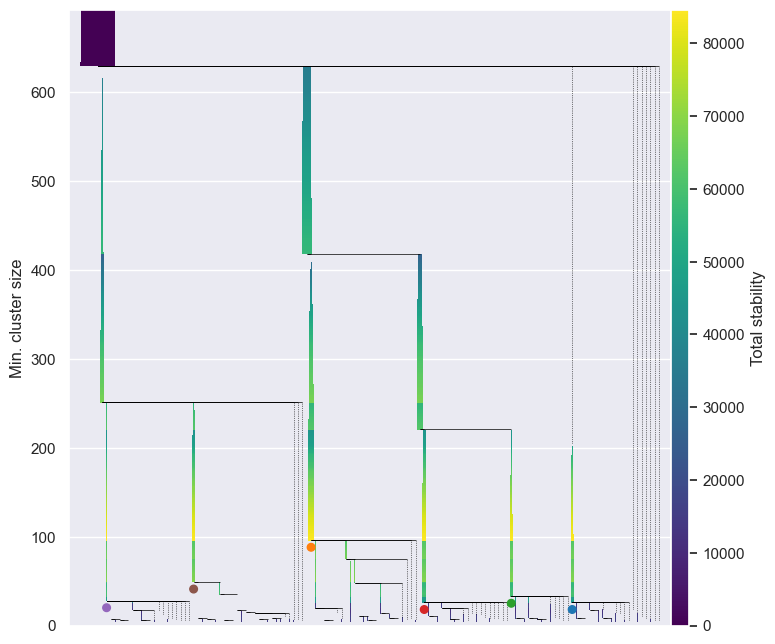

In [151]:
plt.figure()
tree_class = LeafClusterTree(labels, c._condensed_tree, leaves, total_stability)
tree_class.plot(colorbar_kws=dict(pad=0, fraction=0.03))
plt.show()

### EOM-style cluster selection:

EOM-style cluster selection appears less suitable for the leaf-cluster tree.
That approach would always include a segment in all paths below the root. This
includes (potentially) very small and low-stability leaves:

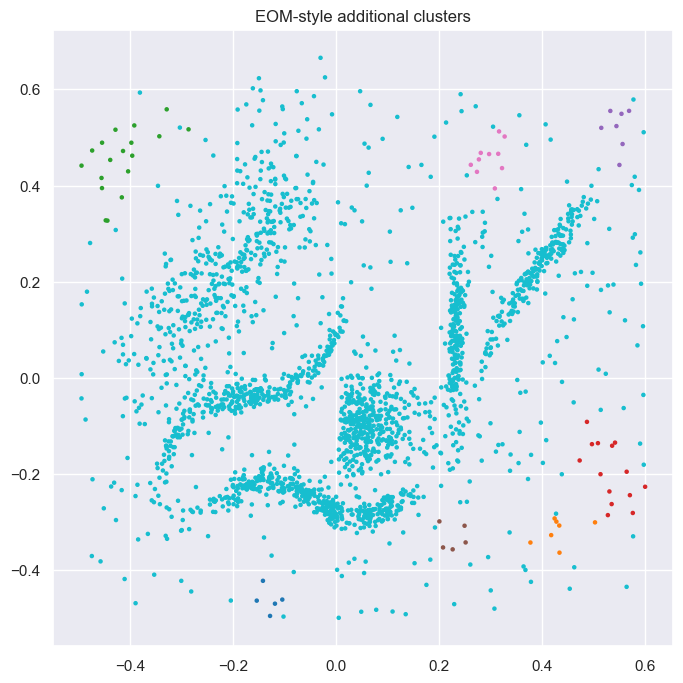

In [84]:
raw_tree = c._condensed_tree
root = raw_tree["parent"][0]
extra_select_leaves = [
    leaf_id
    for leaf_id, leaf in leaves.items()
    if leaf_id != root and leaf["parent"] == root and leaf["death"] < best_size
]


labels = get_cluster_label_vector(
    raw_tree,
    extra_select_leaves,
    cluster_selection_epsilon=0.0,
    n_samples=data.shape[0],

)
probs = get_point_membership_strength_vector(raw_tree, extra_select_leaves, labels)
plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title(f"EOM-style additional clusters")
plt.show()

### Pruning / simplification

Alternatively, the leaf-cluster tree can be simplified with a minimum stability
threshold. After this pruning, the leaf-cluster tree leaves can be used as
high-stability clusters. This would add an additional parameter though...

## Relation to other cluster selection strategies

HDBSCAN* simplifies single linkage dendrograms using a minimum cluster size to
create a cluster hierarchy (`condensed_tree`). The cluster hierarchy forms a
*merge-tree* listing which connected components exist over all density values.
As density decreases, larger distance edges enter the filtration and create
connections between connected components, merging them in the hierarchy. The
process describes the data's 0-dimensional topology in a filtration over the
density, effectively implementing a *persistent homology* computation.

Clusters are selected from the hierarchy using one of two selection strategies.
The *leaf* strategy always selects the cluster tree's leaves. These clusters
correspond to all local density maxima meeting the size threshold. Effectively,
**this strategy defines clusters as local density maxima**. In practice,
leaf-clusters depend strongly on the minimum cluster size value used to
construct the cluster hierarchy. Many small leaf clusters can be detected for
small minimum cluster sizes, resulting in segmentations where most points are
classified as noise. 

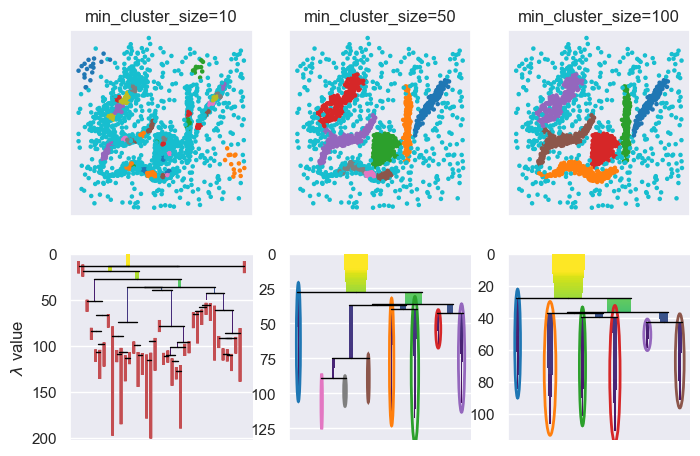

In [131]:
plt.figure(figsize=(8, 8 / 3 * 2))
for i, size in enumerate([10, 50, 100]):
    c = HDBSCAN(
        min_samples=5, min_cluster_size=size, cluster_selection_method="leaf"
    ).fit(data)
    plt.subplot(2, 3, i + 1)
    plt.scatter(
        *data.T,
        c=c.labels_ % 10,
        s=5,
        cmap="tab10",
        vmax=9,
        vmin=0,
    )
    plt.title(f"min_cluster_size={size}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    c.condensed_tree_.plot(
        select_clusters=True,
        selection_palette=plt.cm.tab10.colors,
        colorbar=False,
    )
    if i > 0:
        plt.ylabel("")

plt.show()

The *EOM* strategy is more statistically motivated. It encourages fewer, larger
clusters by **defining clusters as a neighborhoods with an excess of probability
mass** (explained by Müller & Sawitzki, 1991). In statistical terms, the *EOM*
strategy interprets the density profile as a probability distribution and
computes its *modality*. Specifically, the strategy selects connected components
from the hierarchy that maximize a (relative) stability measure. The stability
measure aggregates the density-ranges in which points are part of a particular
connected component. It combines the number of points contained in the component
with the points' *persistence* in the density filtration. Selecting the most
persistent structures from a filtration as the *true* signal is common in
*persistent homology* and clustering (see, *cluster lifetime* referenced by
Campello et al., 2015). The stability adapts this notion to a cluster with
changing membership over density (Campello et al., 2015). While *EOM* clusters
are less sensitive to the minimum cluster size, the vary enough that the
parameter needs to be tuned to avoid small low-density clusters. Notice that some clusters disappear at larger size thresholds.

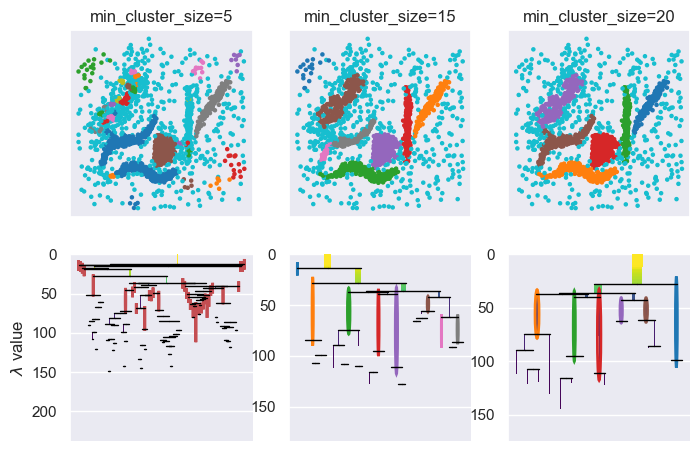

In [132]:
plt.figure(figsize=(8, 8 / 3 * 2))
for i, size in enumerate([5, 15, 20]):
    c = HDBSCAN(min_samples=5, min_cluster_size=size).fit(data)
    plt.subplot(2, 3, i + 1)
    plt.scatter(
        *data.T,
        c=c.labels_ % 10,
        s=5,
        cmap="tab10",
        vmax=9,
        vmin=0,
    )
    plt.title(f"min_cluster_size={size}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    c.condensed_tree_.plot(
        select_clusters=True,
        selection_palette=plt.cm.tab10.colors,
        colorbar=False,
    )
    if i > 0:
        plt.ylabel("")

plt.show()

Both selection strategies can select clusters with varying densities that do not
correspond to a straight density-cut in the cluster hierarchy. In other words,
there may not be a single distance or density value for which DBSCAN produces
the same clusters.

The strategy demonstrated in this notebook combines the *leaf* and *EOM*
strategies. Where HDBSCAN* computes a cluster tree with all possible DBSCAN
clusters, our strategy creates a cluster tree with HDBSCAN* leaf-clusters over
all possible minimum cluster sizes. It then optimizes the minimum cluster size
parameter to find leaf-clusters with a maximal total stability. The result is
**a (practically) parameter free clustering algorithm that produces *EOM*-like
clusters** and a cluster hierarchy describing leaf-clusters at other size
thresholds. When counting the distance metric as input, only the `min_samples`
parameter remains. This parameter smooths the computed density profile which
prunes low stability leaves from the the leaf-cluster tree. **Changing
`min_samples`** changes the optimal minimum cluster size, but **does not really
change which clusters are selected**. As demonstrated above, this is not true
for the other cluster selection strategies and the minimum cluster size
parameter! At higher `min_samples` the selected clusters becomes smaller, with
more points classified as noise. This suggests low `min_samples` values work
better. However, at too low values (i.e. `min_samples=2` below), the resulting
clusters might to sensitive to local density changes. 

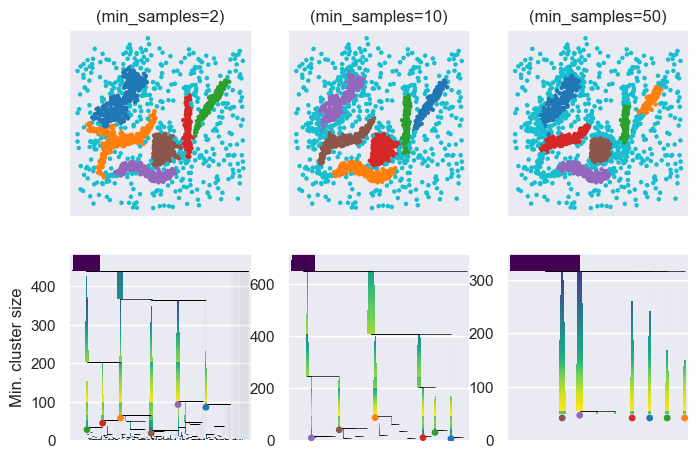

In [156]:
plt.figure(figsize=(8, 8 / 3 * 2))

max_widths = [50, 3, 2]
for i, size in enumerate([2, 10, 50]):
    # Compute initial condensed tree
    c = HDBSCAN(min_cluster_size=size).fit(data)

    # Compute optimal leaf-clustering
    leaves, cluster_tree = extract_leaves(
        c._condensed_tree, data.shape[0], c.min_cluster_size
    )
    total_stability = compute_stabilities(c._condensed_tree, leaves)
    labels, probs, best_size = optimal_clustering(
        c._condensed_tree, leaves, total_stability, data.shape[0]
    )

    plt.subplot(2, 3, i + 1)
    plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
    plt.title(f"(min_samples={size})")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    tree_class = LeafClusterTree(labels, c._condensed_tree, leaves, total_stability)
    tree_class.plot(
        colorbar=False,
        max_width=max_widths[i],
        indicator_radius=15,
        death_line_kws=dict(linewidth=0.1, alpha=0.3),
    )
    if i > 0:
        plt.ylabel("")
plt.show()

Benefits:
- Low parameter sensitivity -> easy to use.
- Statistically motivated cluster definition using probability mass.
- Not much more expensive to compute (right?)